# Import Modules & Util Functions

In [1]:
import os
import sys
import glob
import re
import ast
import warnings
import time

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from my_utils import *

# Configure display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')


# Dual Radio Profiling

In [2]:
class DProfile():
    def __init__(self, filepaths, model_name='Test', sr_model_id=None, dr_model_id=None, load_path='.', save_path='.',
                 scope_agg=None, scope=None, sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']):
        
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        
        if sr_model_id is None:
            raise TypeError("請輸入SR模型編號")
        else:
            self.sr_model_id = sr_model_id
        
        if dr_model_id is None:
            self.dr_model_id = model_identity()
        else:
            self.dr_model_id = dr_model_id
            
        self.model_name = model_name
        self.save_path = save_path
        
        self.load_path = os.path.join(load_path, self.sr_model_id, 'models', self.model_name)
        print(self.load_path)
        
        with open(f'{self.load_path}_kde_models.pkl', 'rb') as f:
            self.kde_models = pickle.load(f)
        with open(f'{self.load_path}_hist_models.pkl', 'rb') as f:
            self.hist_models = pickle.load(f)
        with open(f'{self.load_path}_scope_models.pkl', 'rb') as f:
            self.scope_models = pickle.load(f)
        with open(f'{self.load_path}_plr_models.pkl', 'rb') as f:
            self.plr_models = pickle.load(f)
        with open(f'{self.load_path}_sr_prob_models.pkl', 'rb') as f:
            self.sr_prob_models = pickle.load(f)

        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        
        # 之後用 single radio 的 prob 來當作
        self.dr_prob_models = { mode_mets: { tag: (0.5, 0.5) for tag in \
            list(it.product(['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'SCGF', 'MCGF', 'NASR', 'Stable'], repeat=2)) } 
                               for mode_mets in metrics }
        
        self.corr_data = { mode_mets: { tag: [[], []] for tag in \
            list(it.product(['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'SCGF', 'MCGF', 'NASR', 'Stable'], repeat=2)) } 
                               for mode_mets in metrics }
        
        self.dr_prob_models_adjust = { mode_mets: None for mode_mets in metrics }
        self.dr_prob_models_table = None
        
        
        # Construct profiles
        self.construct_profile()
    
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
       
    
    def setup_profile(self, df, ho_df, df2, scope):
        
        this_df = df2.copy()
        this_df = this_df[this_df['lost']].copy().reset_index(drop=True)
        
        df['anchor_type'] = 'Stable'
        df['anchor_state'] = 0
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DProfile.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DProfile.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DProfile.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DProfile.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_type'] = tag
            
            if not this_df[(this_df['Timestamp'] >= interval.lower) & (this_df['Timestamp'] < interval.upper)].empty:
                df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_state'] = 1
                
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
            
        return df
    
    
    def setup_profile_stage2(self, df, ho_df, scope):
        
        this_df = df.copy()
        this_df = this_df[this_df['lost']].copy().reset_index(drop=True)
        
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    # left = prior_row['end'] + (start_ts - prior_row['end']) / 2
                    left_bound = min(max(current_left_bound, DProfile.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    # left = prior_row['start'] + (start_ts - prior_row['start']) / 2
                    left_bound = min(max(current_left_bound, DProfile.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                # left_bound = pd.Timestamp.min
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    # right = end_ts + (post_row['start'] - end_ts) / 2
                    right_bound = max(min(current_right_bound, DProfile.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    # right = start_ts + (post_row['start'] - start_ts) / 2
                    right_bound = max(min(current_right_bound, DProfile.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                # right_bound = pd.Timestamp.max
                right_bound = current_right_bound
            
            # interval = P.closed(max(start_ts+pd.Timedelta(seconds=scope[tag][0]), left_bound), min(start_ts+pd.Timedelta(seconds=scope[tag][1]), right_bound))
            interval = P.closed(left_bound, right_bound)
            
            anchor_tag = row['anchor_type']
            anchor_state = row['anchor_state']
            
            self.corr_data['dl_lost'][(anchor_tag, tag)][0].append(anchor_state)
            if not this_df[(this_df['Timestamp'] >= interval.lower) & (this_df['Timestamp'] < interval.upper)].empty:
                self.corr_data['dl_lost'][(anchor_tag, tag)][1].append(1)
            else:
                self.corr_data['dl_lost'][(anchor_tag, tag)][1].append(0)
                
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
    

    def estimate_probability(self):
        for key, lst in self.corr_data['dl_lost'].items():
            # print(key, lst)
            
            # 生成的数据
            data = {
                'first_distribution_samples': np.array(lst[0]),  # 第一个分布的样本数据
                'second_distribution_samples': np.array(lst[1])  # 第二个分布的样本数据
            }
            
            def log_likelihood(params, data):
                p, success_prob_when_first_is_success, success_prob_when_first_is_failure = params
                first_samples = data['first_distribution_samples']
                second_samples = data['second_distribution_samples']
                log_likelihood_val = 0.0
                for first_sample, second_sample in zip(first_samples, second_samples):
                    # 添加检查以确保概率值在有效范围内
                    if not 0 <= success_prob_when_first_is_success <= 1:
                        return float('inf')  # 返回无穷大值表示非法参数
                    if not 0 <= success_prob_when_first_is_failure <= 1:
                        return float('inf')  # 返回无穷大值表示非法参数
                    # 计算对数似然函数值
                    if first_sample == 1:
                        log_likelihood_val += np.log(success_prob_when_first_is_success if second_sample == 1 else (1 - success_prob_when_first_is_success))
                    else:
                        log_likelihood_val += np.log(success_prob_when_first_is_failure if second_sample == 1 else (1 - success_prob_when_first_is_failure))
                return -log_likelihood_val  # 取负对数似然函数，因为我们要最大化对数似然函数

            # 使用最大似然估计估算参数
            initial_guess = [0.5, 0.5, 0.5]  # 初始猜测值
            # result = minimize(likelihood, initial_guess, args=(data,), method='Nelder-Mead')
            result = minimize(log_likelihood, initial_guess, args=(data,), method='Nelder-Mead')

            # 输出估计的参数值
            estimated_params = result.x
            # print("Estimated parameters:")
            # print(f"p: {estimated_params[0]}")
            # print(f"success_prob_when_first_is_success: {estimated_params[1]}")
            # print(f"success_prob_when_first_is_failure: {estimated_params[2]}")
            self.dr_prob_models['dl_lost'][key] = (estimated_params[1], estimated_params[2])
        
        stable_prob = self.sr_prob_models['dl_lost']['Stable']
        self.dr_prob_models['dl_lost'][('Stable', 'Stable')] = (stable_prob, stable_prob)
    
    
    def construct_profile(self):
        n = len(self.filepaths)
        scope = self.scope_models['dl_lost']
    
        for i, filepath in enumerate(self.filepaths):
            
            # if i > 35:
            #     break
            
            # if i > 0:
            #     break
            
            print(f'{i}/{n}', filepath[0][0]); print(f'{i}/{n}', filepath[0][1]); print(f'{i}/{n}', filepath[0][2])
            print(f'{i}/{n}', filepath[1][0]); print(f'{i}/{n}', filepath[1][1]); print(f'{i}/{n}', filepath[1][2])
                
            ho_df1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
            ho_df2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
            
            if ho_df1.empty or ho_df2.empty:
                continue
            
            # df, ho_df, empty_data = data_aligner(df, ho_df)
            
            df1 = pd.read_csv(filepath[0][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
            df2 = pd.read_csv(filepath[1][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
            df1, ho_df1, empty_data1 = data_aligner(df1, ho_df1)
            df2, ho_df2, empty_data2 = data_aligner(df2, ho_df2)
            
            if empty_data1 or empty_data2:
                continue
            
            df = pd.merge(df1, df2, on='seq', how='inner').reset_index(drop=True)
            
            df1 = df[['seq', 'Timestamp_x', 'lost_x', 'excl_x', 'latency_x']].rename(columns={'Timestamp_x': 'Timestamp', 'lost_x': 'lost', 'excl_x': 'excl', 'latency_x': 'latency'})
            df2 = df[['seq', 'Timestamp_y', 'lost_y', 'excl_y', 'latency_y']].rename(columns={'Timestamp_y': 'Timestamp', 'lost_y': 'lost', 'excl_y': 'excl', 'latency_y': 'latency'})
            
            # display(df1)
            # display(df2)
            # display(ho_df1)
            # display(ho_df2)
            
            ho_df1 = self.setup_profile(ho_df1, ho_df2, df2, scope)
            ho_df2 = self.setup_profile(ho_df2, ho_df1, df1, scope)
            
            # display(ho_df1)
            # display(ho_df2)
            
            self.setup_profile_stage2(df1, ho_df1, scope)
            self.setup_profile_stage2(df2, ho_df2, scope)
            
            self.estimate_probability()
    
    
    def adjust_parameters(self):
        
        sr_prob_models, dr_prob_models = self.sr_prob_models['dl_lost'], self.dr_prob_models['dl_lost']
        
        def calculate_rho_conditional(p, q, alpha):
            """
            p := P(X = 1); P(X = 0) = 1 - p
            q := P(Y = 1); P(Y = 0) = 1 - q
            alpha := P(Y = 1 | X = 1); P(Y = 0 | X = 1) = 1 - alpha
            rho: correlation coefficient
            """
            sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
            rho = (p * alpha - p * q) / sigma
            return rho

        def rho_restriction(p, q):
            sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
            R1 = P.closed(-1, 1)  # -1 <= rho <= 1
            R2 = P.closed(-(p * q) / sigma, (1 - p * q) / sigma)  # 0 <= P(X=1, Y=1) <= 1
            R3 = P.closed((p * (1 - q) - 1) / sigma, p * (1 - q) / sigma)  # 0 <= P(X=1, Y=0) <= 1
            R4 = P.closed((q * (1 - p) - 1) / sigma, q * (1 - p) / sigma)  # 0 <= P(X=0, Y=1) <= 1
            R5 = P.closed(-((1 - p) * (1 - q)) / sigma, (1 - (1 - p) * (1 - q)) / sigma)  # 0 <= P(X=0, Y=0) <= 1
            R = R1 & R2 & R3 & R4 & R5
            return R

        def calculate_joint_probabilities(p, q, rho):
            """
            p := P(X = 1); P(X = 0) = 1 - p
            q := P(Y = 1); P(Y = 0) = 1 - q
            rho: correlation coefficient
            a := P(X = 1, Y = 1)
            b := P(X = 1, Y = 0)
            c := P(X = 0, Y = 1)
            d := P(X = 0, Y = 0)
            """
            sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
            a = p * q + rho * sigma
            b = p * (1 - q) - rho * sigma
            c = q * (1 - p) - rho * sigma
            d = (1 - p) * (1 - q) + rho * sigma
            return a, b, c, d

        def calculate_conditional_probabilities(p, q, rho):
            """
            p := P(X = 1); P(X = 0) = 1 - p
            q := P(Y = 1); P(Y = 0) = 1 - q
            rho: correlation coefficient
            alpha := P(Y = 1 | X = 1)
            beta  := P(Y = 1 | X = 0)
            gamma := P(X = 1 | Y = 1)
            delta := P(X = 1 | Y = 0)
            """
            sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
            p = min(max(1e-9, p), 1 - 1e-9)
            q = min(max(1e-9, q), 1 - 1e-9)
            alpha = (p * q + rho * sigma) / p
            beta = (q * (1 - p) - rho * sigma) / (1 - p)
            gamma = (p * q + rho * sigma) / q
            delta = (p * (1 - q) - rho * sigma) / (1 - q)
            return alpha, beta, gamma, delta

        def generate_combos(items):
            combinations_result = list(it.combinations(items, 2))
            self_combinations = [(x, x) for x in items]
            def custom_sort(item):
                return items.index(item[0]), items.index(item[1])
            combos = sorted(self_combinations + combinations_result, key=custom_sort)
            return combos

        def adjust_rho(rho, rho_limit):
            if rho > rho_limit.upper:
                return rho_limit.upper
            elif rho < rho_limit.lower:
                return rho_limit.lower
            else:
                return rho
        
        table = pd.DataFrame(columns="type1, type2, p, q, rho1, rho2, alpha, beta, gamma, delta, rho, alpha_ad, beta_ad, gamma_ad, delta_ad".split(", "))
        items = ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'SCGF', 'MCGF', 'NASR', 'Stable']
        combos = generate_combos(items)

        for pair in combos:
            p = sr_prob_models[pair[0]]
            q = sr_prob_models[pair[1]]
            alpha, beta = dr_prob_models[pair]
            gamma, delta = dr_prob_models[(pair[1], pair[0])]
            rho_limit = rho_restriction(p, q)
            rho1 = adjust_rho(calculate_rho_conditional(p, q, alpha), rho_limit)
            rho2 = adjust_rho(calculate_rho_conditional(q, p, gamma), rho_limit)
            rho = adjust_rho(np.mean([rho1, rho2]), rho_limit)
            # a, b, c, d = calculate_joint_probabilities(p, q, rho)
            alpha_ad, beta_ad, gamma_ad, delta_ad = calculate_conditional_probabilities(p, q, rho)
            table.loc[len(table)] = [pair[0], pair[1], p, q, rho1, rho2, alpha, beta, gamma, delta, rho, alpha_ad, beta_ad, gamma_ad, delta_ad]
        
        table = table.set_index(['type1', 'type2'])
        model_adjust = copy.deepcopy(dr_prob_models)
        for pair in combos:
            row = table.loc[pair]
            p, q, alpha, beta, gamma, delta = row['p'], row['q'], row['alpha_ad'], row['beta_ad'], row['gamma_ad'], row['delta_ad']
            model_adjust[pair] = (alpha, beta)
            model_adjust[(pair[1], pair[0])] = (gamma, delta)
        
        self.dr_prob_models_adjust['dl_lost'] = model_adjust
        self.dr_prob_models_table = table
        # return table, model_adjust
            
    def save_models(self):
        
        self.adjust_parameters()
        
        save_path = os.path.join(self.save_path, self.sr_model_id, self.dr_model_id)
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        
        save_path = os.path.join(save_path, self.model_name)
        print(save_path)
        print()
        
        with open(f'{save_path}_dr_prob_models.pkl', 'wb') as f:
            pickle.dump(self.dr_prob_models, f)
        with open(f'{save_path}_dr_prob_models_adjust.pkl', 'wb') as f:
            pickle.dump(self.dr_prob_models_adjust, f)
            
        self.dr_prob_models_table.to_csv(f'{save_path}_dr_prob_models_table.csv')

# Generate DR Model ID

In [10]:
sr_model_id = '20240312_150032342e_newest'
dr_model_id = model_identity()
# dr_model_id = dr_model_id + '_test'
print('SR Model ID:', sr_model_id)
print('DR Model ID:', dr_model_id)


SR Model ID: 20240312_150032342e_newest
DR Model ID: 20240314_060073cc2b


# BR Model

In [11]:
# Dual Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

In [12]:
dr_model = DProfile(filepaths, 'BR', sr_model_id=sr_model_id, dr_model_id=dr_model_id, metrics=['dl_lost'])
dr_model.save_models()

./20240312_150032342e_newest/models/BR
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv
1/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
1/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
1/216 /home/wmnlab/jackbedford/data/2

# A Model

In [13]:
# Dual Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

In [14]:
dr_model = DProfile(filepaths, 'A', sr_model_id=sr_model_id, dr_model_id=dr_model_id, metrics=['dl_lost'])
dr_model.save_models()

./20240312_150032342e_newest/models/A
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
1/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
1/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
1/216 /home/wmnlab/jackbedford/data/20

# Dual Radio Evaluation

In [9]:
class DEval:
    def __init__(self, filepaths, model_name='Trial',
                 sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost']):
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        self.model_name = model_name
        with open(f'{model_name}_kde_models.pkl', 'rb') as f:
            self.kde_models = pickle.load(f)
        with open(f'{model_name}_hist_models.pkl', 'rb') as f:
            self.hist_models = pickle.load(f)
        with open(f'{model_name}_scope_models.pkl', 'rb') as f:
            self.scope_models = pickle.load(f)
        with open(f'{model_name}_sr_prob_models.pkl', 'rb') as f:
            self.sr_prob_models = pickle.load(f)
        with open(f'{model_name}_dr_prob_models.pkl', 'rb') as f:
            self.dr_prob_models = pickle.load(f)
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        
        
        # Sample data
        self.LOSS_GT = []
        self.LOSS_EV = []

        # Standard deviations for error bars
        self.LOSS_STD = []
        
        self.DEVICES = []
        self.TRACES = []

    @staticmethod
    def generate_random_boolean(probability_true):
        return random.random() < probability_true
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def hist_method(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        prob_model = self.sr_prob_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DREval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DREval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DREval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DREval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            trigger_probability = prob_model[tag]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not DREval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        # display(answer)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        trig_p_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        triggered_p = prob_model['Stable']
        random_bool_array = [DREval.generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        trig_p_mapping['trigger'] = random_bool_array
        trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        stable_df = pd.merge(stable_df, trig_p_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_trig'] * stable_df['trigger']

        del stable_df['Timestamp_sec'], stable_df['PLR_trig'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        # display(answer)
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(DREval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        return answer, eval_value, ground_value
    
    
    def setup_profile(self, df, ho_df, df2, scope):
        
        this_df = df2.copy()
        this_df = this_df[this_df['Y']].copy().reset_index(drop=True)
        
        df['anchor_type'] = 'Stable'
        df['anchor_state'] = 0
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    # left = prior_row['end'] + (start_ts - prior_row['end']) / 2
                    left_bound = min(max(current_left_bound, DREval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    # left = prior_row['start'] + (start_ts - prior_row['start']) / 2
                    left_bound = min(max(current_left_bound, DREval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                # left_bound = pd.Timestamp.min
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    # right = end_ts + (post_row['start'] - end_ts) / 2
                    right_bound = max(min(current_right_bound, DREval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    # right = start_ts + (post_row['start'] - start_ts) / 2
                    right_bound = max(min(current_right_bound, DREval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                # right_bound = pd.Timestamp.max
                right_bound = current_right_bound
            
            # interval = P.closed(max(start_ts+pd.Timedelta(seconds=scope[tag][0]), left_bound), min(start_ts+pd.Timedelta(seconds=scope[tag][1]), right_bound))
            interval = P.closed(left_bound, right_bound)
            
            df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_type'] = tag
            
            if not this_df[(this_df['Timestamp'] >= interval.lower) & (this_df['Timestamp'] < interval.upper)].empty:
                df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_state'] = 1
                
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
            
        return df
    
    
    def hist_method_dual(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        dr_prob_model = self.dr_prob_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DREval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DREval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DREval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DREval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            anchor_tag = row['anchor_type']
            anchor_state = row['anchor_state']
            
            if anchor_state == 1:
                trigger_probability = dr_prob_model[(anchor_tag, tag)][0]
            else:
                trigger_probability = dr_prob_model[(anchor_tag, tag)][1]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not DREval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        # display(answer)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        trig_p_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        
        triggered_p = dr_prob_model[('Stable', 'Stable')][0]
        
        random_bool_array = [DREval.generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        trig_p_mapping['trigger'] = random_bool_array
        trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        stable_df = pd.merge(stable_df, trig_p_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_trig'] * stable_df['trigger']

        del stable_df['Timestamp_sec'], stable_df['PLR_trig'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        # display(answer)
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(DREval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        return answer, eval_value, ground_value
    
    
    def hist_method_all(self, N=1):
        scope = self.scope_models['dl_lost']
        
        for mode_mets in ['dl_lost']:
            for i, filepath in enumerate(filepaths):
                
                if i > 35:
                    break
                
                # print(f'{i}/{n}', filepath[0][0]); print(f'{i}/{n}', filepath[0][1]); print(f'{i}/{n}', filepath[0][2])
                # print(f'{i}/{n}', filepath[1][0]); print(f'{i}/{n}', filepath[1][1]); print(f'{i}/{n}', filepath[1][2])
                    
                ho_df1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
                ho_df2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
                
                if ho_df1.empty or ho_df2.empty:
                    print('******** Empty RRC Data ********')
                    continue
                
                # df, ho_df, empty_data = data_aligner(df, ho_df)
                
                df1 = pd.read_csv(filepath[0][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df2 = pd.read_csv(filepath[1][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df1, ho_df1, empty_data1 = data_aligner(df1, ho_df1)
                df2, ho_df2, empty_data2 = data_aligner(df2, ho_df2)
                
                if empty_data1 or empty_data2:
                    print('******** Empty RRC Data ********')
                    continue
                
                df = pd.merge(df1, df2, on='seq', how='inner').reset_index(drop=True)
                
                df1 = df[['seq', 'Timestamp_x', 'lost_x', 'excl_x', 'latency_x']].rename(columns={'Timestamp_x': 'Timestamp', 'lost_x': 'lost', 'excl_x': 'excl', 'latency_x': 'latency'})
                df2 = df[['seq', 'Timestamp_y', 'lost_y', 'excl_y', 'latency_y']].rename(columns={'Timestamp_y': 'Timestamp', 'lost_y': 'lost', 'excl_y': 'excl', 'latency_y': 'latency'})
                
                loss_rate_list = []
                for iter_round in tqdm(range(N), ncols=1000):
                    answer1, eval_value1, ground_value1 = eval.hist_method(df1, ho_df1, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    # display(answer1)
                    
                    # setup_profile
                    # ho_df1 = self.setup_profile(ho_df1, ho_df2, df2, scope)
                    avatar_ho_df2 = self.setup_profile(ho_df2.copy(), ho_df1, answer1, scope)
                    
                    # display(avatar_ho_df2)
                    
                    answer2, eval_value2, ground_value2 = eval.hist_method_dual(df2, avatar_ho_df2, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    
                    # display(answer2)
                    
                    answer = pd.merge(answer1, answer2, on='seq', how='inner').reset_index(drop=True)
                    
                    
                    handle = (answer1['Y']) & (answer2['Y'])
                    eval_value = handle.mean() * 100
                    # print('eval:', eval_value, len(handle))
                    
                    handle = (df1['lost']) & (df2['lost'])
                    ground_value = handle.mean() * 100
                    # print('ground:', ground_value, len(handle))
                    
                    loss_rate_list.append(eval_value)
        
                mean_value = np.mean(loss_rate_list)
                std_deviation = np.std(loss_rate_list)

                print()
                print("Mean:", mean_value)
                print("Standard Deviation:", std_deviation)
                print("Ground Truth:", ground_value)
                
                self.LOSS_GT.append(ground_value)
                self.LOSS_EV.append(mean_value)
                self.LOSS_STD.append(std_deviation)
                
                path1 = filepath[0][0]
                path2 = filepath[1][0]

                def find_sm_label(path):
                    # 找到 "sm" 的位置
                    sm_index = path.index("sm")
                    # 从 "sm" 的位置开始找到下一个斜杠 "/"
                    next_slash_index = path.index("/", sm_index)
                    # 截取 "sm00" 标签
                    # sm_label = path[sm_index:next_slash_index]
                    sm_label = path[sm_index+2:next_slash_index]
                    # print("截取的标签为:", sm_label)
                    return sm_label
                
                self.DEVICES.append(find_sm_label(path1)+'+'+find_sm_label(path2))
                
                def find_tr_label(path):
                    # 找到 "sm" 的位置
                    sm_index = path.index("#")
                    # 从 "sm" 的位置开始找到下一个斜杠 "/"
                    next_slash_index = path.index("/", sm_index)
                    # 截取 "sm00" 标签
                    # sm_label = path[sm_index:next_slash_index]
                    sm_label = path[sm_index+1:next_slash_index]
                    # print("截取的标签为:", sm_label)
                    return sm_label
                
                self.TRACES.append(find_tr_label(path1)+'+'+find_tr_label(path2))
    
    
    def plot(self):
        # Sample data
        x = self.LOSS_GT.copy()
        y = self.LOSS_EV.copy()

        # Standard deviations for error bars
        y_error = self.LOSS_STD.copy()

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(6, 4))

        # Scatter plot with error bars and horizontal caps
        ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
        ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

        # Regression line
        coefficients = np.polyfit(x, y, 1)
        regression_line = np.poly1d(coefficients)
        ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

        # Annotate the slope of the regression line
        slope_annotation = f'Slope: {coefficients[0]:.2f}'
        ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # Annotate MSE From the regression line
        y_pred = regression_line(x)
        mse = mean_squared_error(y, y_pred)
        slope_annotation = f'MSE: {mse:.3f}'
        ax.annotate(slope_annotation, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # 45-Degree Line
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)

        # Set labels and title
        ax.set_xlabel('PLR Ground Truth')
        ax.set_ylabel('PLR Evaluated')
        # ax.set_title('A Profile Evaluate 9 Traces From A5 Data: Single')

        for i, sm_label in enumerate(self.DEVICES):
            ax.annotate(sm_label, xy=(x[i], y[i]))
            
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()

# Enter Model IDs

In [ ]:
# sr_model_id = '20240312_150032342e_newest'
# dr_model_id = ''
print('SR Model ID:', sr_model_id)
print('DR Model ID:', dr_model_id)


# BR: DR Eval

In [10]:
# Dual Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths[:36]))
# pprint(filepaths[:36])

  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.025326439462402234
Standard Deviation: 0.0
Ground Truth: 0.10292834310764584


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.05015904862888019
Standard Deviation: 0.0
Ground Truth: 0.18575073845266038


  0%|                                                                                                         …


Mean: 0.012910134879163255
Standard Deviation: 0.0
Ground Truth: 0.0


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.005008850144374815
Standard Deviation: 0.0
Ground Truth: 0.0


  0%|                                                                                                         …


Mean: 0.01735460754248175
Standard Deviation: 0.0
Ground Truth: 0.07894230016275236


  0%|                                                                                                         …


Mean: 0.02772504375689158
Standard Deviation: 0.0
Ground Truth: 0.03901259337801792


  0%|                                                                                                         …


Mean: 0.0028218874052815856
Standard Deviation: 0.0
Ground Truth: 0.00973551154822147


  0%|                                                                                                         …


Mean: 0.007336907253732122
Standard Deviation: 0.0
Ground Truth: 0.08663194334214468


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.06680818432004154
Standard Deviation: 0.0
Ground Truth: 0.1549921657350911


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.031887327679681915
Standard Deviation: 0.0
Ground Truth: 0.06370410817423179


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.00599651073622337
Standard Deviation: 0.0
Ground Truth: 0.0034568120714699425


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.07181703446441635
Standard Deviation: 0.0
Ground Truth: 0.20331698755053823


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.06730201461596581
Standard Deviation: 0.0
Ground Truth: 0.15788460032550472


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.02582026975832651
Standard Deviation: 0.0
Ground Truth: 0.017001871616821554


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.014462172952068125
Standard Deviation: 0.0
Ground Truth: 0.1034221734035701


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.005714321995695211
Standard Deviation: 0.0
Ground Truth: 0.024479873240817757


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.017777890653273988
Standard Deviation: 0.0
Ground Truth: 0.017072418801953593


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.04670223655741024
Standard Deviation: 0.0
Ground Truth: 0.20649161088148


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.08515045245437185
Standard Deviation: 0.0
Ground Truth: 0.23167695597361818


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.01982375902210314
Standard Deviation: 0.0
Ground Truth: 0.02553808101779835


  0%|                                                                                                         …

Overlapping event occurs!!

Mean: 0.012134115842710817
Standard Deviation: 0.0
Ground Truth: 0.04366870759673254


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.005643774810563171
Standard Deviation: 0.0
Ground Truth: 7.054718513203964e-05


  0%|                                                                                                         …


Mean: 0.01968266465183906
Standard Deviation: 0.0
Ground Truth: 0.10419819244002254


  0%|                                                                                                         …


Mean: 0.032240063605342116
Standard Deviation: 0.0
Ground Truth: 0.05171108670178505


  0%|                                                                                                         …


Mean: 0.07132320416849208
Standard Deviation: 0.0
Ground Truth: 0.08493881089897573


  0%|                                                                                                         …


Mean: 0.002751340220149546
Standard Deviation: 0.0
Ground Truth: 7.054718513203964e-05


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.012134115842710817
Standard Deviation: 0.0
Ground Truth: 0.00790128473478844


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.014814908877728326
Standard Deviation: 0.0
Ground Truth: 0.04084682019145095


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.004585567033582576
Standard Deviation: 0.0
Ground Truth: 0.02885379871900421


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.00395064236739422
Standard Deviation: 0.0
Ground Truth: 0.0


  0%|                                                                                                         …


Mean: 0.06828967520781437
Standard Deviation: 0.0
Ground Truth: 0.21135936665559077


  0%|                                                                                                         …


Mean: 0.02335111827870512
Standard Deviation: 0.0
Ground Truth: 0.06892459987400273


  0%|                                                                                                         …


Mean: 0.015379286358784642
Standard Deviation: 0.0
Ground Truth: 0.06483286313634443


  0%|                                                                                                         …


Mean: 0.014744361692596285
Standard Deviation: 0.0
Ground Truth: 0.0003527359256601982


  0%|                                                                                                         …


Mean: 0.032381157975606194
Standard Deviation: 0.0
Ground Truth: 0.03520304538088778


  0%|                                                                                                         …


Mean: 0.022434004871988603
Standard Deviation: 0.0
Ground Truth: 0.007407454438864163


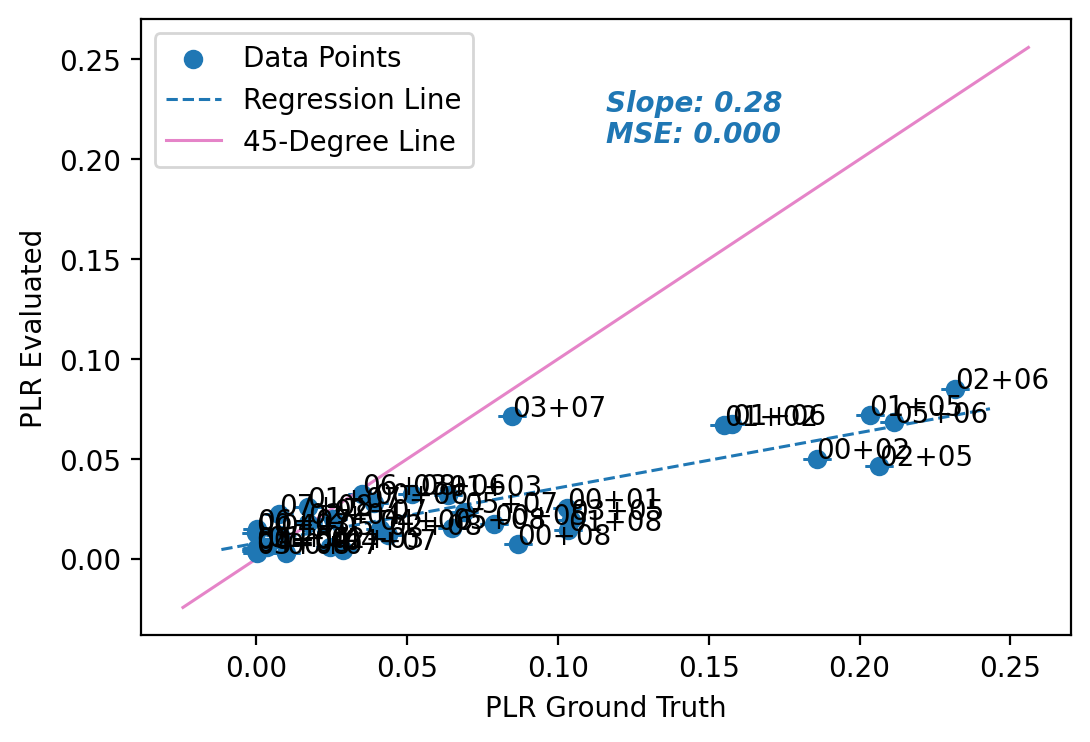

In [11]:
eval = DREval(filepaths, model_name='BR')
eval.hist_method_all()
eval.plot()

# A: Dual Eval

In [12]:
# Dual Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths[:36]))
# pprint(filepaths[:36])

  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.07675193995229072
Standard Deviation: 0.0
Ground Truth: 0.6584598501029485


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.04469627046798619
Standard Deviation: 0.0
Ground Truth: 0.4393566471814857
******** Empty RRC Data ********


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.03941778886055177
Standard Deviation: 0.0
Ground Truth: 0.25134748340577256


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.08025613822226975
Standard Deviation: 0.0
Ground Truth: 0.642049105778158


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.12088430132281694
Standard Deviation: 0.0
Ground Truth: 0.6533621360454835


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.04491734263327212
Standard Deviation: 0.0
Ground Truth: 0.31016607123606854


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.0658066787796536
Standard Deviation: 0.0
Ground Truth: 0.06461019371093263


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.209230232742993
Standard Deviation: 0.0
Ground Truth: 0.5897420775844164
******** Empty RRC Data ********


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.09017882631406808
Standard Deviation: 0.0
Ground Truth: 0.24066592431406433


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.19164938667464182
Standard Deviation: 0.0
Ground Truth: 0.5812891520768642


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.18790551145324325
Standard Deviation: 0.0
Ground Truth: 0.875819542551842


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.15016576863502343
Standard Deviation: 0.0
Ground Truth: 0.3602843693321406


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.10982877821680799
Standard Deviation: 0.0
Ground Truth: 0.12093986083796365
******** Empty RRC Data ********


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.08535794566205815
Standard Deviation: 0.0
Ground Truth: 0.29407371977260566


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.23821308951114736
Standard Deviation: 0.0
Ground Truth: 0.7844848227882004


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.17115020892063668
Standard Deviation: 0.0
Ground Truth: 0.7940309471384405


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.11867634737843477
Standard Deviation: 0.0
Ground Truth: 0.29125350591679605


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.059738790216854375
Standard Deviation: 0.0
Ground Truth: 0.09597519515526103
******** Empty RRC Data ********
******** Empty RRC Data ********
******** Empty RRC Data ********
******** Empty RRC Data ********
******** Empty RRC Data ********


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.09019351382762156
Standard Deviation: 0.0
Ground Truth: 0.29017136767627244


  0%|                                                                                                         …


Mean: 0.09683996887489563
Standard Deviation: 0.0
Ground Truth: 0.338040595163492


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.03470455736086499
Standard Deviation: 0.0
Ground Truth: 0.10080397315172228


  0%|                                                                                                         …


Mean: 0.037149139141958866
Standard Deviation: 0.0
Ground Truth: 0.016164129244974467


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.13792359203394228
Standard Deviation: 0.0
Ground Truth: 0.7170701507598577


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.13543223325008022
Standard Deviation: 0.0
Ground Truth: 0.3651275722423546


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.09350597236273882
Standard Deviation: 0.0
Ground Truth: 0.16978716034286784


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.07999000361611613
Standard Deviation: 0.0
Ground Truth: 0.3201493399168104


  0%|                                                                                                         …


Mean: 0.06758918648746381
Standard Deviation: 0.0
Ground Truth: 0.10961943690823964


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.04463365415348303
Standard Deviation: 0.0
Ground Truth: 0.040567452609839454


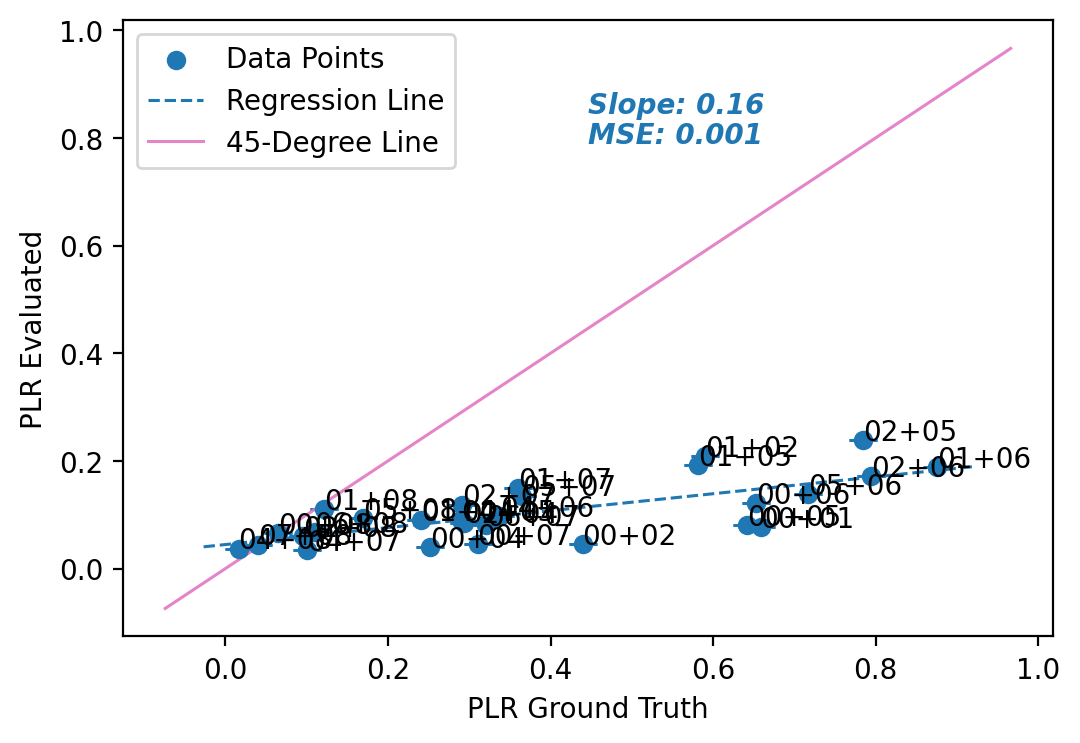

In [13]:
eval = DREval(filepaths, model_name='A')
eval.hist_method_all()
eval.plot()

# Show Model IDs

In [2]:
print('SR Model ID:', sr_model_id)
print('DR Model ID:', dr_model_id)


NameError: name 'sr_model_id' is not defined

In [53]:
import pickle


with open('/home/wmnlab/jackbedford/udp-reliability-research/handover_profiling/20240312_150032342e_newest/models/BR_sr_prob_models.pkl', 'rb') as f:
    sr_prob_models = pickle.load(f)
with open('/home/wmnlab/jackbedford/udp-reliability-research/handover_profiling/BR_dr_prob_models.pkl', 'rb') as f:
    dr_prob_models = pickle.load(f)
    
sr_prob_models = sr_prob_models['dl_lost']
dr_prob_models = dr_prob_models['dl_lost']

In [54]:
sr_prob_models

{'LTEH': 0.05683563748079877,
 'ENBH': 0.04375396322130628,
 'MCGH': 0.1103030303030303,
 'MNBH': 0.21378165213781652,
 'SCGM': 0.23580470162748643,
 'SCGA': 0.09040590405904059,
 'SCGR-I': 0.08571428571428572,
 'SCGR-II': 0.04736842105263158,
 'SCGC-I': 0.6,
 'SCGC-II': 0.13533834586466165,
 'SCGF': 0.051347881899871634,
 'MCGF': 0.8805394990366089,
 'NASR': 0.8461538461538461,
 'Stable': 0.010493874051807399}

In [55]:
dr_prob_models

{'dl_lost': {('LTEH', 'LTEH'): (0.6035912662636055, 0.023887822717013993),
  ('LTEH', 'ENBH'): (0.5341279446478091, 0.01420373958485578),
  ('LTEH', 'MCGH'): (0.2856436487995655, 0.09973690182685474),
  ('LTEH', 'MNBH'): (0.8017956331318028, 0.17834758487922125),
  ('LTEH', 'SCGM'): (0.5000000778010127, 0.21988413335644333),
  ('LTEH', 'SCGA'): (0.6476638077191583, 0.05682521605346346),
  ('LTEH', 'SCGR-I'): (0.627027027027027, 0.05309446254071662),
  ('LTEH', 'SCGR-II'): (0.4583570412517781, 0.022602005828904505),
  ('LTEH', 'SCGC-I'): (0.7500000000000001, 0.5909609120521172),
  ('LTEH', 'SCGC-II'): (0.8017956331318028, 0.09517723897722805),
  ('LTEH', 'SCGF'): (0.4758612913298408, 0.025766454947251344),
  ('LTEH', 'MCGF'): (0.9999988685431156, 0.8733408073888227),
  ('LTEH', 'NASR'): (0.7500000000000001, 0.8519481332999248),
  ('LTEH', 'Stable'): (0.1480399052833156, 0.002205269563915212),
  ('ENBH', 'LTEH'): (0.6938229132940407, 0.027689667964145126),
  ('ENBH', 'ENBH'): (0.60359126

In [33]:
def adjust_parameters(sr_prob_models, dr_prob_models):
    
    def calculate_rho_conditional(p, q, alpha):
        """
        p := P(X = 1); P(X = 0) = 1 - p
        q := P(Y = 1); P(Y = 0) = 1 - q
        alpha := P(Y = 1 | X = 1); P(Y = 0 | X = 1) = 1 - alpha
        rho: correlation coefficient
        """
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        rho = (p * alpha - p * q) / sigma
        return rho

    def rho_restriction(p, q):
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        R1 = P.closed(-1, 1)  # -1 <= rho <= 1
        R2 = P.closed(-(p * q) / sigma, (1 - p * q) / sigma)  # 0 <= P(X=1, Y=1) <= 1
        R3 = P.closed((p * (1 - q) - 1) / sigma, p * (1 - q) / sigma)  # 0 <= P(X=1, Y=0) <= 1
        R4 = P.closed((q * (1 - p) - 1) / sigma, q * (1 - p) / sigma)  # 0 <= P(X=0, Y=1) <= 1
        R5 = P.closed(-((1 - p) * (1 - q)) / sigma, (1 - (1 - p) * (1 - q)) / sigma)  # 0 <= P(X=0, Y=0) <= 1
        R = R1 & R2 & R3 & R4 & R5
        return R

    def calculate_joint_probabilities(p, q, rho):
        """
        p := P(X = 1); P(X = 0) = 1 - p
        q := P(Y = 1); P(Y = 0) = 1 - q
        rho: correlation coefficient
        a := P(X = 1, Y = 1)
        b := P(X = 1, Y = 0)
        c := P(X = 0, Y = 1)
        d := P(X = 0, Y = 0)
        """
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        a = p * q + rho * sigma
        b = p * (1 - q) - rho * sigma
        c = q * (1 - p) - rho * sigma
        d = (1 - p) * (1 - q) + rho * sigma
        return a, b, c, d

    def calculate_conditional_probabilities(p, q, rho):
        """
        p := P(X = 1); P(X = 0) = 1 - p
        q := P(Y = 1); P(Y = 0) = 1 - q
        rho: correlation coefficient
        alpha := P(Y = 1 | X = 1)
        beta  := P(Y = 1 | X = 0)
        gamma := P(X = 1 | Y = 1)
        delta := P(X = 1 | Y = 0)
        """
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        p = min(max(1e-9, p), 1 - 1e-9)
        q = min(max(1e-9, q), 1 - 1e-9)
        alpha = (p * q + rho * sigma) / p
        beta = (q * (1 - p) - rho * sigma) / (1 - p)
        gamma = (p * q + rho * sigma) / q
        delta = (p * (1 - q) - rho * sigma) / (1 - q)
        return alpha, beta, gamma, delta

    def generate_combos(items):
        combinations_result = list(it.combinations(items, 2))
        self_combinations = [(x, x) for x in items]
        def custom_sort(item):
            return items.index(item[0]), items.index(item[1])
        combos = sorted(self_combinations + combinations_result, key=custom_sort)
        return combos

    def adjust_rho(rho, rho_limit):
        if rho > rho_limit.upper:
            return rho_limit.upper
        elif rho < rho_limit.lower:
            return rho_limit.lower
        else:
            return rho
    
    table = pd.DataFrame(columns="type1, type2, p, q, rho1, rho2, alpha, beta, gamma, delta, rho, alpha_ad, beta_ad, gamma_ad, delta_ad".split(", "))
    items = ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'SCGF', 'MCGF', 'NASR', 'Stable']
    combos = generate_combos(items)

    for pair in combos:
        p = sr_prob_models[pair[0]]
        q = sr_prob_models[pair[1]]
        alpha, beta = dr_prob_models[pair]
        gamma, delta = dr_prob_models[(pair[1], pair[0])]
        rho_limit = rho_restriction(p, q)
        rho1 = adjust_rho(calculate_rho_conditional(p, q, alpha), rho_limit)
        rho2 = adjust_rho(calculate_rho_conditional(q, p, gamma), rho_limit)
        rho = adjust_rho(np.mean([rho1, rho2]), rho_limit)
        # a, b, c, d = calculate_joint_probabilities(p, q, rho)
        alpha_ad, beta_ad, gamma_ad, delta_ad = calculate_conditional_probabilities(p, q, rho)
        table.loc[len(table)] = [pair[0], pair[1], p, q, rho1, rho2, alpha, beta, gamma, delta, rho, alpha_ad, beta_ad, gamma_ad, delta_ad]
    
    table = table.set_index(['type1', 'type2'])
    model_adjust = copy.deepcopy(dr_prob_models)
    for pair in combos:
        row = table.loc[pair]
        p, q, alpha, beta, gamma, delta = row['p'], row['q'], row['alpha_ad'], row['beta_ad'], row['gamma_ad'], row['delta_ad']
        model_adjust[pair] = (alpha, beta)
        model_adjust[(pair[1], pair[0])] = (gamma, delta)
    
    return table, model_adjust
        
table, model_adjust = adjust_parameters(sr_prob_models, dr_prob_models)
display(table)
# table.to_csv('test.csv')
model_adjust

p         q      rho1      rho2         alpha  \
type1   type2                                                           
LTEH    LTEH     0.056836  0.056836  0.102892  0.102892  1.538794e-01   
        ENBH     0.056836  0.043754  0.080825  0.409440  1.111014e-01   
        MCGH     0.056836  0.110303 -0.086430 -0.086401  6.182098e-06   
        MNBH     0.056836  0.213782  0.051625  0.153521  3.000000e-01   
        SCGM     0.056836  0.235805 -0.136357  0.008913  6.534491e-06   
        SCGA     0.056836  0.090406  0.350618  0.376514  4.999866e-01   
        SCGR-I   0.056836  0.085714  0.454125  0.723061  6.035913e-01   
        SCGR-II  0.056836  0.047368  0.642774  0.526588  6.035913e-01   
        SCGC-I   0.056836  0.600000 -0.050108 -0.300562  5.000000e-01   
        SCGC-II  0.056836  0.135338  0.301560 -0.097108  5.555720e-01   
        SCGF     0.056836  0.051348  0.596600  0.194055  5.877389e-01   
        MCGF     0.056836  0.880539  0.090415  0.090418  9.999965e-01   
        NASR     0.056836  0.846154 -0.235515  0.104673  5.000000e-01   
        Stable   0.056836  0.010494  0.419510  0.237927  5.000000e-01   
ENBH    ENBH     0.043754  0.043754  0.186606  0.186606  2.221955e-01   
        MCGH     0.043754  0.110303  0.308655 -0.074018  5.623303e-01   
        MNBH     0.043754  0.213782 -0.022720  0.093336  1.702365e-01   
        SCGM     0.043754  0.235805 -0.118822 -0.118821  1.811886e-07   
        SCGA     0.043754  0.090406 -0.067201  0.678499  3.158044e-04   
        SCGR-I   0.043754  0.085714  0.316560  0.682954  5.000000e-01   
        SCGR-II  0.043754  0.047368  0.560100  0.610310  6.035913e-01   
        SCGC-I   0.043754  0.600000 -0.174608 -0.261981  2.001044e-01   
        SCGC-II  0.043754  0.135338 -0.084627 -0.084627  3.284791e-07   
        SCGF     0.043754  0.051348  0.126463  0.612236  1.818310e-01   
        MCGF     0.043754  0.880539  0.078788 -0.003785  9.999993e-01   
        NASR     0.043754  0.846154 -0.205223  0.091210  5.000000e-01   
        Stable   0.043754  0.010494  0.481432  0.277006  5.000000e-01   
MCGH    MCGH     0.110303  0.110303 -0.123961 -0.123961  1.499172e-05   
        MNBH     0.110303  0.213782 -0.183606 -0.183605  1.518502e-07   
        SCGM     0.110303  0.235805 -0.195590 -0.065848  3.791907e-07   
        SCGA     0.110303  0.090406  0.196070  0.485059  2.500893e-01   
        SCGR-I   0.110303  0.085714  0.521081  0.380889  5.000000e-01   
        SCGR-II  0.110303  0.047368  0.633300  0.633295  6.035913e-01   
        SCGC-I   0.110303  0.600000 -0.071873 -0.431174  5.000000e-01   
        SCGC-II  0.110303  0.135338  0.403064 -0.139299  5.269311e-01   
        SCGF     0.110303  0.051348 -0.081918 -0.081918  1.060650e-07   
        MCGF     0.110303  0.880539 -0.738708 -0.955949  2.001044e-01   
        NASR     0.110303  0.846154 -0.337811  0.150138  5.000000e-01   
        Stable   0.110303  0.010494  0.292473  0.157504  5.000000e-01   
MNBH    MNBH     0.213782  0.213782  0.012165  0.012165  2.233461e-01   
        SCGM     0.213782  0.235805  0.057998  0.187085  2.830194e-01   
        SCGA     0.213782  0.090406 -0.024488  0.274897  7.693930e-02   
        SCGR-I   0.213782  0.085714 -0.159661 -0.010215  9.746697e-10   
        SCGR-II  0.213782  0.047368  0.374619  0.212020  1.999784e-01   
        SCGC-I   0.213782  0.600000  0.425704 -0.140673  9.999447e-01   
        SCGC-II  0.213782  0.135338 -0.206300 -0.013312  4.549504e-07   
        SCGF     0.213782  0.051348 -0.121314 -0.121317  1.210109e-06   
        MCGF     0.213782  0.880539 -0.067241  0.063077  8.387170e-01   
        NASR     0.213782  0.846154 -0.500282  0.222348  5.000000e-01   
        Stable   0.213782  0.010494  0.197490  0.089884  5.000000e-01   
SCGM    SCGM     0.235805  0.235805  0.094642  0.094642  3.081297e-01   
        SCGA     0.235805  0.090406 -0.175123  0.250016  9.553198e-07   
        SCGR-I   0.235805  0.085714  0.551203  0.190560  5.000000e-01   
        S

{('LTEH', 'LTEH'): (0.1538793731087096, 0.05098772507325365),
 ('LTEH', 'ENBH'): (0.2480110413499265, 0.03144531193342526),
 ('LTEH', 'MCGH'): (2.4557707163879147e-05, 0.11694847572004506),
 ('LTEH', 'MNBH'): (0.3850879710690402, 0.203458632918834),
 ('LTEH', 'SCGM'): (0.12561245433024867, 0.24244495105745026),
 ('LTEH', 'SCGA'): (0.5151123535475194, 0.0648128443993114),
 ('LTEH', 'SCGR-I'): (0.7569360744494946, 0.045266067174867586),
 ('LTEH', 'SCGR-II'): (0.5533206138600009, 0.016879445264565352),
 ('LTEH', 'SCGC-I'): (0.2500882612977424, 0.6210858865341752),
 ('LTEH', 'SCGC-II'): (0.2777933049803896, 0.12675392650426762),
 ('LTEH', 'SCGF'): (0.40677897483231445, 0.029929395843682084),
 ('LTEH', 'MCGF'): (0.9999982437342735, 0.8733408450401698),
 ('LTEH', 'NASR'): (0.7500000000000001, 0.8519481332999248),
 ('LTEH', 'Stable'): (0.14694730420212898, 0.0022711103456805283),
 ('ENBH', 'LTEH'): (0.32216203058231174, 0.04469537148344838),
 ('ENBH', 'ENBH'): (0.22219552476436905, 0.03558919